#  CNN 

## NE IZVRSAVATI OVU SVESKU

Sveska u kojoj eksperimentisemo sa **CNN** modelima.
Za pregledanje ce biti ostavljeni samo neki od najuspesnijih.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalMaxPool1D, Conv1D, Embedding, Dropout, MaxPool1D, Flatten
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import L2

In [13]:
from sklearn import feature_extraction
from sklearn import metrics
from sklearn import datasets

In [14]:
import nltk
import pickle

In [15]:
import string

In [16]:
import gensim

In [17]:
import os

In [18]:
import graphviz
import pydot

In [19]:
max_doc_len = 400

## Ucitavanje i priprema podataka

In [20]:
train_data = datasets.fetch_20newsgroups(random_state=61, remove=('headers'))
test_data = datasets.fetch_20newsgroups(random_state=61, subset='test', remove=('headers'))
X_train = train_data.data
y_train = train_data.target
X_test = test_data.data
y_test = test_data.target
feature_names = train_data.target_names
num_of_features = len(feature_names)
N_train = len(X_train)
N_test = len(X_test)

In [29]:
X_train_tok = [nltk.tokenize.word_tokenize(text) for text in X_train]
X_test_tok = [nltk.tokenize.word_tokenize(text) for text in X_test] 

1. Koristimo nase istrenirane embedding-e:

NAPOMENA - kao sto je naglaseno u 01 svesci, ovo necemo koristiti, lose se pokazalo.

In [11]:
# ucitavamo vec istrenirane embedding-e

cbow_model_full = gensim.models.word2vec.Word2Vec.load(os.path.join("models", "cbow2.wv"))

In [12]:
cbow = cbow_model_full.wv

In [18]:
# vidimo da nam fale neke reci iz originalnog vokabulara koje smo hteli da naucimo
# verovatno su se retko pojavljivale pa nisu uzete u obzir

In [16]:
# 0 cemo koristiti kao indeks za padding i nikako ne bi trebalo da predstavlja smislenu rec
# pomericemo vokabular za jedno mesto napred, a atribut maske_zero postaviti na True pri treniranju

In [17]:
cbow_vocab_plus1 = { word : cbow.key_to_index[word] + 1 for word in cbow.key_to_index}
cbow_key_to_index = cbow_vocab_plus1
cbow_index_to_key = { cbow_key_to_index[word] : word for word in cbow_key_to_index }

In [18]:
# pripremamo matricu w2v (cbow) vektora (vektor 0-te - nepostojece reci je 0 vektor - uopste nema uticaj)

In [19]:
cbow_matrix = np.vstack([np.zeros(300), cbow.vectors])

In [21]:
# pripremamo trening i test skup

X_train_idx = [[cbow_key_to_index[word] if word in cbow_key_to_index else 0 for word in text ] for text in X_train_tok_filt]
#X_train_idx = [[cbow_key_to_index[word] for word in text if word in cbow_key_to_index] for text in X_train_tok_filt]

In [22]:
X_test_idx = [[cbow_key_to_index[word] for word in text if word in cbow_key_to_index ] for text in X_test_tok_filt]

In [27]:
# vrsimo odsecanje na 400 reci i pre-padding nulama

In [23]:
X_train_input = pad_sequences(X_train_idx, maxlen=max_doc_len)
X_test_input = pad_sequences(X_test_idx, maxlen=max_doc_len)

In [29]:
V_cbow = len(cbow_key_to_index)

---

2. Koristimo google-ov word2vec:

In [30]:
# kako je izuzetno velik (3GB) koristicemo nase ranije istrenirane embedding-e

In [21]:
with open(os.path.join("data", "googlew2v_vocab.pickle"), "rb") as load_file:
    googlew2v_vocab = pickle.load(load_file)
with open(os.path.join("data", "googlew2v_vectors.pickle"), "rb") as load_file:
    googlew2v_vectors = pickle.load(load_file)

In [22]:
googlew2v_index_to_key = { index : key for (key,index) in zip(list(googlew2v_vocab.keys()), range(1,len(googlew2v_vocab)+1))}

In [23]:
googlew2v_key_to_index = { googlew2v_index_to_key[index] : index for index in googlew2v_index_to_key }

In [24]:
V_googlew2v = len(googlew2v_key_to_index)

In [31]:
X_train_tok_filt = [[word for word in text if word in googlew2v_key_to_index] for text in X_train_tok]
X_test_tok_filt = [[word for word in text if word in googlew2v_key_to_index] for text in X_test_tok]

In [32]:
googlew2v_matrix = np.zeros((V_googlew2v+1,300))

In [33]:
for i in range(1, V_googlew2v):
    googlew2v_matrix[i] = googlew2v_vectors[googlew2v_index_to_key[i]]

In [34]:
X_google_train_idx = [[googlew2v_key_to_index[word] for word in text if word in googlew2v_key_to_index] for text in X_train_tok_filt]

X_google_test_idx = [[googlew2v_key_to_index[word] for word in text if word in googlew2v_key_to_index] for text in X_test_tok_filt]

In [36]:
X_train_google_input = pad_sequences(X_google_train_idx, maxlen=max_doc_len)
X_test_google_input = pad_sequences(X_google_test_idx, maxlen=max_doc_len)

In [37]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

## CNN

### CNN modeli

Modeli sa vec spremnim embedingom (word2vec)
1. CNN1 (filter_size=1, num_of_filters=600)
2. CNN2 (filter_size=2, num_of_filters=800) **<--- ova je ispala najbolje na kraju**
3. CNN3 (filter_size=3, num_of_filters=600)

Modeli kod kojih treniramo i embeding

4. CNN1e (filter_size=1, num_of_filters=600)
5. CNN2e (filter_size=2, num_of_filters=800)
6. CNN3e (filter_size=3, num_of_filters=600)

Eksperimentalni modeli (sa i bez ranije treniranog embedinga)

7. CNN5 (filter_size=5, num_of_filters=600)
8. CNN5e (filter_size=5, num_of_filters=600)

In [50]:
def plot_train_val_performance(history):

    plt.figure(figsize=(10, 4))

    plt.subplot(121)
    plt.title('Loss')
    plt.plot(history.epoch, history.history['loss'], label='train')
    plt.plot(history.epoch, history.history['val_loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(122)
    plt.title('Accuracy')
    plt.plot(history.epoch, history.history['accuracy'], label='train')
    plt.plot(history.epoch, history.history['val_accuracy'], label='val')
    plt.legend(loc='best')

    plt.show()

In [51]:
embedding_dim = 300

In [52]:
def train_model(X, y, V_size, filter_size=1, filters=600,
                batch_size=128, epochs=20, learning_rate=0.0001,
                dropout_rate=0.25, val_split=0.1, l2=0,
                embedding_trainable=False, embedding_matrix=[]):
    
    embedding_layer = Embedding(input_dim=V_size, output_dim=embedding_dim, input_length=max_doc_len, mask_zero=True,
                               trainable=embedding_trainable, weights=[embedding_matrix])
    dropout_layer = Dropout(dropout_rate)
    conv_layer = Conv1D(filters, filter_size, activation='relu', kernel_regularizer=L2(l2))
    global_max_pool_layer = GlobalMaxPool1D()
    dense_layer = Dense(20, activation='softmax', activity_regularizer=L2(l2))
    
        
        
    cnn = Sequential([
        embedding_layer,
        dropout_layer,
        conv_layer,
        global_max_pool_layer,
        #Dropout(0.5),
        dense_layer
    ])
    
    cnn.compile(optimizer=Adam(learning_rate=learning_rate), loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])
    
    print(cnn.summary(), "\n")
    
    history = cnn.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=val_split, verbose=1)
    
    return cnn, history
    
    
        
        
        

In [53]:
def test_model(cnn, history, x_test):
    print(cnn.summary())
    plot_train_val_performance(history)
    
    score = cnn.evaluate(x_test, y_test_cat)
    test_loss = score[0]
    #Ovo je bitno
    test_accuracy = score[1]
    
    print("Test loss: ", test_loss)
    print("Test accuracy: ", test_accuracy, "\n")
    
    
    y_predicted = cnn.predict(x_test)
    y_predicted_int = np.array([yp.argmax() for yp in y_predicted])
                                                        #uvezi feature_names.txt i dodaj target_names=feature_names
    print("Classification report: ", metrics.classification_report(y_test, y_predicted_int))
    
    
    confusion_matrix = metrics.confusion_matrix(y_test, y_predicted_int)
    
    #poigraj se tu malo sa matricom konfuzije
    #print(confusion_matrix)

In [44]:
# namerno ostavljen primer modela gde koristimo nase embedding-e
# najbolji moguci parametri, preciznost jedva 60% na test skupu

In [55]:
model3, history = train_model(X_train_input, y_train_cat, filter_size=2, V_size=V_cbow+1,
                              filters=800, batch_size=64, epochs=25, 
                              learning_rate=0.0001, dropout_rate=0.25, l2=0.0001,
                             embedding_trainable=False, embedding_matrix=cbow_matrix)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 400, 300)          44123100  
                                                                 
 dropout_6 (Dropout)         (None, 400, 300)          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 399, 800)          480800    
                                                                 
 global_max_pooling1d_6 (Glo  (None, 800)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 20)                16020     
                                                                 
Total params: 44,619,920
Trainable params: 496,820
Non-trainable params: 44,123,100
____________________________________

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 400, 300)          44123100  
                                                                 
 dropout_6 (Dropout)         (None, 400, 300)          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 399, 800)          480800    
                                                                 
 global_max_pooling1d_6 (Glo  (None, 800)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 20)                16020     
                                                                 
Total params: 44,619,920
Trainable params: 496,820
Non-trainable params: 44,123,100
____________________________________

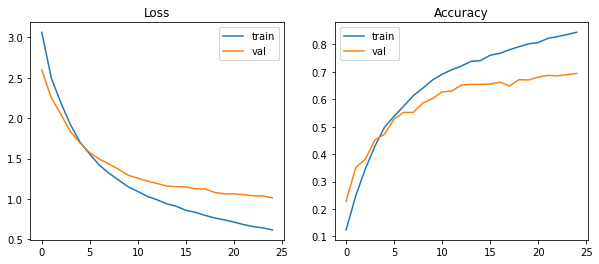

236/236 [==============================] - 10s 40ms/step - loss: 1.2714 - accuracy: 0.6097
Test loss:  1.271366834640503
Test accuracy:  0.6096654534339905 

236/236 [==============================] - 9s 40ms/step
Classification report:                precision    recall  f1-score   support

           0       0.49      0.47      0.48       319
           1       0.54      0.46      0.49       389
           2       0.62      0.55      0.58       394
           3       0.46      0.44      0.45       392
           4       0.51      0.49      0.50       385
           5       0.65      0.71      0.68       395
           6       0.68      0.81      0.74       390
           7       0.69      0.65      0.67       396
           8       0.79      0.74      0.77       398
           9       0.67      0.49      0.57       397
          10       0.65      0.83      0.73       399
          11       0.75      0.72      0.74       396
          12       0.44      0.49      0.46       393
     

In [56]:
test_model(model3, history, X_test_input)

In [45]:
# model koji inicijalno koristi google vektore, a jos ih dalje trenira (dobar rezultat)

In [46]:
model_google2, historyg2 = train_model(X_train_google_input, y_train_cat,V_size=V_googlew2v+1,
                                    filter_size=2, filters=800, batch_size=64,
                                    epochs=15, learning_rate=0.0001, dropout_rate=0.1, 
                                    l2=0.00001,
                                    embedding_trainable=True, embedding_matrix=googlew2v_matrix)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 400, 300)          25938300  
                                                                 
 dropout_2 (Dropout)         (None, 400, 300)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 399, 800)          480800    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 800)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 20)                16020     
                                                                 
Total params: 26,435,120
Trainable params: 26,435,120
Non-trainable params: 0
__________________________________________

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 400, 300)          25938300  
                                                                 
 dropout_2 (Dropout)         (None, 400, 300)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 399, 800)          480800    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 800)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 20)                16020     
                                                                 
Total params: 26,435,120
Trainable params: 26,435,120
Non-trainable params: 0
__________________________________________

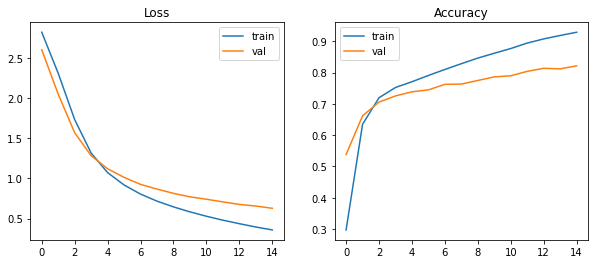

236/236 [==============================] - 10s 44ms/step - loss: 0.8171 - accuracy: 0.7612
Test loss:  0.8171089887619019
Test accuracy:  0.7611523866653442 

236/236 [==============================] - 10s 43ms/step
Classification report:                precision    recall  f1-score   support

           0       0.59      0.59      0.59       319
           1       0.70      0.72      0.71       389
           2       0.64      0.72      0.68       394
           3       0.66      0.66      0.66       392
           4       0.74      0.71      0.73       385
           5       0.82      0.70      0.75       395
           6       0.76      0.81      0.78       390
           7       0.85      0.84      0.85       396
           8       0.92      0.88      0.90       398
           9       0.90      0.92      0.91       397
          10       0.95      0.95      0.95       399
          11       0.83      0.81      0.82       396
          12       0.64      0.64      0.64       393
   

In [50]:
test_model(model_google2, historyg2, X_test_google_input)

In [47]:
# najbolji model

In [54]:
%%time
model_google4, historyg4 = train_model(X_train_google_input, y_train_cat,V_size=V_googlew2v+1,
                                    filter_size=2, filters=800, batch_size=64,
                                    epochs=40, learning_rate=0.0001, dropout_rate=0.25, 
                                    l2=0.0001,
                                    embedding_trainable=False, embedding_matrix=googlew2v_matrix)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 400, 300)          25938300  
                                                                 
 dropout_1 (Dropout)         (None, 400, 300)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 399, 800)          480800    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 800)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 20)                16020     
                                                                 
Total params: 26,435,120
Trainable params: 496,820
Non-trainable params: 25,938,300
____________________________________

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 400, 300)          25938300  
                                                                 
 dropout_1 (Dropout)         (None, 400, 300)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 399, 800)          480800    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 800)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 20)                16020     
                                                                 
Total params: 26,435,120
Trainable params: 496,820
Non-trainable params: 25,938,300
____________________________________

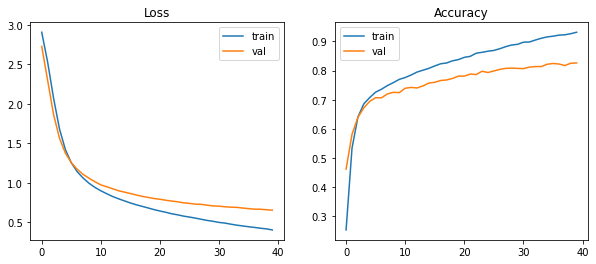

236/236 [==============================] - 10s 40ms/step - loss: 0.8750 - accuracy: 0.7639
Test loss:  0.8750002980232239
Test accuracy:  0.7639405131340027 

236/236 [==============================] - 10s 41ms/step
Classification report:                precision    recall  f1-score   support

           0       0.58      0.61      0.59       319
           1       0.75      0.69      0.72       389
           2       0.65      0.73      0.69       394
           3       0.65      0.71      0.68       392
           4       0.74      0.74      0.74       385
           5       0.80      0.69      0.74       395
           6       0.79      0.83      0.81       390
           7       0.85      0.84      0.85       396
           8       0.93      0.89      0.91       398
           9       0.89      0.93      0.91       397
          10       0.94      0.96      0.95       399
          11       0.85      0.79      0.82       396
          12       0.66      0.65      0.65       393
   

In [55]:
test_model(model_google4, historyg4, X_test_google_input)

In [56]:
model_path = os.path.join("models", "best_cnn.hdf5")

In [57]:
model_google4.save(model_path)